In [1]:
from __future__ import print_function
import keras
from keras import backend as K
from keras import Input, layers
from keras import Model
import seaborn as sns

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.interactive(True)

import os
import random

from os import listdir
from os.path import isfile, join
import uuid
import time


w,h = 256,256                       # initial data size
window = 7                          # window for the first max-pool operation

run_uuid = uuid.uuid4()             #unique identifier is generated for each run


1. Data Augmentation: Increase training set variability to prevent overfitting.
2. Regularization Techniques: Use dropout, batch normalization, and early stopping.
3. Adjust Learning Rate: Implement learning rate schedulers.
4. Early Stopping: Halt training when validation accuracy plateaus.
5. Balanced Class Sampling: Balance classes if they're imbalanced.
6. Transfer Learning (Fine-tuning): Utilize a pre-trained model as a feature extractor.
7. Evaluation Metrics: Compute precision, recall, F1-score, and confusion matrix for better understanding.

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense,Flatten,Dropout,BatchNormalization,Activation,Input,SeparableConv2D,GlobalAveragePooling2D,concatenate
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import*
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Adamax
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model,Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
path = "/kaggle/input/training/"          #training data path
vpath = "/kaggle/input/validation/"       #validation data path

In [4]:
import os

# Check contents of input folder
print("Datasets available:", os.listdir('/kaggle/input/'))

# Confirm the exact dataset name
dataset_name = 'us-manufacturing'  # Adjust if needed after checking above
training_path = f"/kaggle/input/{dataset_name}/training/"
validation_path = f"/kaggle/input/{dataset_name}/validation/"

# Confirm these folders exist
print("Training folder:", os.path.exists(training_path))
print("Validation folder:", os.path.exists(validation_path))

# List files to confirm contents
if os.path.exists(training_path):
    print("Training files:", os.listdir(training_path))
if os.path.exists(validation_path):
    print("Validation files:", os.listdir(validation_path))

Datasets available: ['validation', 'training']
Training folder: False
Validation folder: False


In [5]:
'''     The data_generator reads raw binary UT data from the pre-processed files
        and preconditions it for ML training. '''
def data_generator(batch_size=10):
    input_files = [f for f in listdir(path) if isfile(join(path, f)) and f.endswith('.bins')]
    np.random.shuffle(input_files)
    input_files = input_files[:100]
    xs, ys = [], []
    for file in input_files:
        x_data = np.fromfile(join(path, file), dtype=np.uint16).astype('float32')
        x_data -= x_data.mean()
        x_data /= x_data.std() + 1e-5
        x_data = np.reshape(x_data, (-1, 256, 256, 1), 'C')
        y_data = np.loadtxt(join(path, file.replace('.bins', '.labels')))[:, 0]

        xs.extend(x_data)
        ys.extend(y_data)

    xs = np.array(xs)
    ys = np.array(ys)

    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    while True:
        for batch in datagen.flow(xs, ys, batch_size=batch_size):
            yield batch


In [6]:
# Improved data augmentation
data_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# # Update your data generator to include augmentation
# def data_generator_aug(batch_size=10):
#     gen = data_generator(batch_size=batch_size)
#     while True:
#         xs, ys = next(gen)
#         for x, y in data_generator(batch_size):
#             yield next(data_generator(batch_size))


In [7]:
# Step 1: Get data from your existing data_generator function first
gen = data_generator(batch_size=10)
batch_data, batch_labels = next(gen)

# Verify shapes
print("Batch data shape:", batch_data.shape)
print("Batch labels shape:", batch_labels.shape)

Batch data shape: (10, 256, 256, 1)
Batch labels shape: (10,)


In [8]:
generator = data_gen.flow(batch_data, batch_labels, batch_size=10)  # correct
batch_data_aug, batch_labels_aug = next(generator)

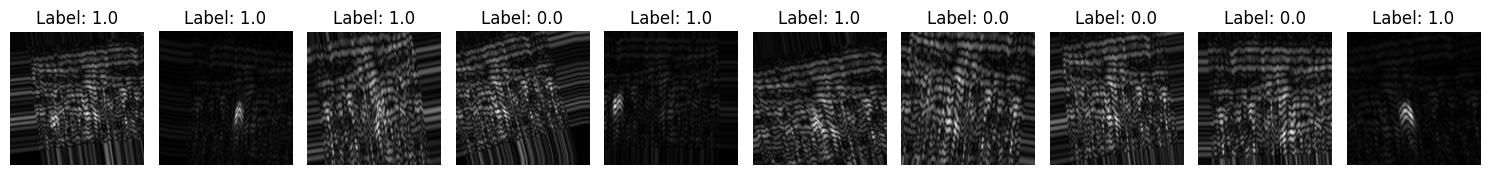

In [9]:
# Step 5: Visualize augmented samples
num_samples = batch_data_aug.shape[0]
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
for i in range(num_samples):
    axes[i].imshow(batch_data_aug[i, :, :, 0], cmap='gray')
    axes[i].set_title(f'Label: {batch_labels_aug[i]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Saved image 1/10: sample_images/sample_1.png
Saved image 2/10: sample_images/sample_2.png
Saved image 3/10: sample_images/sample_3.png
Saved image 4/10: sample_images/sample_4.png
Saved image 5/10: sample_images/sample_5.png
Saved image 6/10: sample_images/sample_6.png
Saved image 7/10: sample_images/sample_7.png
Saved image 8/10: sample_images/sample_8.png
Saved image 9/10: sample_images/sample_9.png
Saved image 10/10: sample_images/sample_10.png


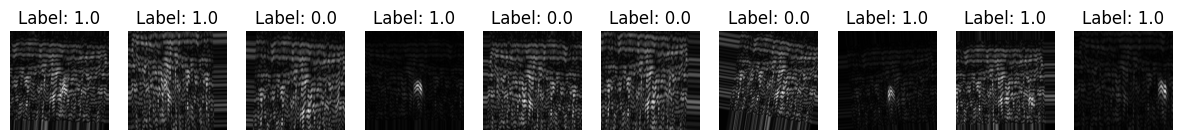

In [10]:
num_samples=batch_data.shape[0]

#create a directory to save the images
save_dir="sample_images"
os.makedirs(save_dir,exist_ok=True)

#Plot the first few samples
fig,axes=plt.subplots(1,num_samples,figsize=(15,3))
for i in range(num_samples):
    axes[i].imshow(batch_data[i,:,:,0],cmap='gray')
    axes[i].set_title('Label: {}'.format(batch_labels[i]))
    axes[i].axis('off')
    
    #save the plot as an image (e.g.,PNG format)
    image_path=os.path.join(save_dir,f"sample_{i+1}.png") #Define the image path
    plt.savefig(image_path) #save the current subplot as an image
    #plt.close(fig)#close the figure to release memory
    
    #Display a message for each saved image
    print(f"Saved image {i+1}/{num_samples}: {image_path}")
    
plt.show()
    
#Display a final message after all images have been saved
#print(f"All {num_samples} images saved to '{save_dir}'.")



# #optionally show the last saved image
# if num_samples>0:
#     last_image_path=os.path.join(save_dir,f"sample_{num_samples}.png")
#     last_image=plt.imread(last_image_path)
#     plt.figure(figsize=(30,20))
#     plt.imshow(last_image,cmap='gray')
#     plt.title(f"Last Saved Image: sample_{num_samples}.png")
#     plt.axis('off')
#     plt.show()


# #Save each plot individually
# for i in range(num_samples):
#   plt.figure(figsize=(4,4))
#   plt.imshow(batch_data[i,:,:,0],cmap='gray')
#   plt.title('Label: {}'.format(batch_labels[i]))
#   plt.axis('off')
#   plt.savefig('sample_{}.png'.format(i)) #Save each plot waith a unique name
#   plt.close() #close the figure to avoid displaying it

# plt.show()

In [11]:
unique_labels=np.unique(batch_labels)
num_classes=len(unique_labels)
print("Number of Unique Labels:",num_classes)

if num_classes==2:
    print("Binary Classification Problem")
else:
    print("Multiclass Classification Problem")

Number of Unique Labels: 2
Binary Classification Problem


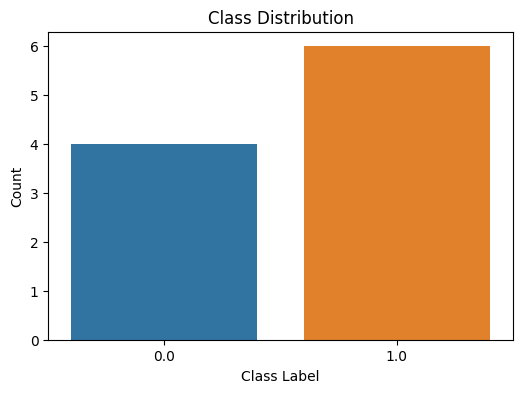

In [12]:
#Class Distribution analysis
plt.figure(figsize=(6,4))
sns.countplot(x=batch_labels)
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

/tmp/ipykernel_23/1064468891.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_0_data[:,:,:,i].flatten(),label='Class 0',shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_23/1064468891.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_1_data[:,:,:,i].flatten(),label='Class 1',shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating inste

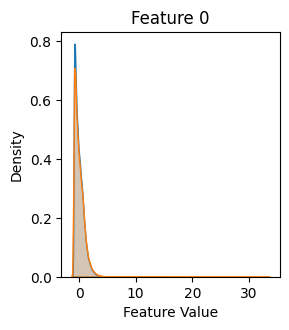

In [13]:
#Downsample the data to reduce RAM usage
subset_size=50
downsampled_batch_data=batch_data[:subset_size]
downsampled_batch_labels=batch_labels[:subset_size]

#Feature Analysis
class_0_data=batch_data[downsampled_batch_labels==0]
class_1_data=batch_data[downsampled_batch_labels==1]

plt.figure(figsize=(10,6))
for i in range(batch_data.shape[-1]):  #Assuming images are grayscale
    plt.subplot(2,4,i+1)
    sns.kdeplot(class_0_data[:,:,:,i].flatten(),label='Class 0',shade=True)
    sns.kdeplot(class_1_data[:,:,:,i].flatten(),label='Class 1',shade=True)
    plt.title(f'Feature {i}')
    plt.xlabel('Feature Value')
    plt.ylabel('Density')
plt.tight_layout()
plt.show()

# #Correlation Analysis(Assume batch_data contains flattened features)
# plt.figure(figsize=(8,6))
# corr_matrix=np.corrcoef(batch_data.reshape(batch_data.shape[0],-1),rowvar=False)
# sns.heatmap(corr_matrix,cmap='coolwarm',annot=True)
# plt.title('Feature Correlation')
# plt.show()

# Dimensionality Reduction(assuming both batch_data contains flattened features)
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
reduced_data=pca.fit_transform(batch_data.reshape(batch_data.shape[0],-1))

# plt.figure(figsize=(6,4))
# sns.scatterplot(x=reduced_data[:,0],y=reduced_data[:,1],hue=batch_labels,palette='Set1')
# plt.title('PCA Visualization')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend(title='Class')
# plt.show()

In [14]:
import scipy.stats

#Basic Statistics
mean=np.mean(batch_data)
median=np.median(batch_data)
mode=scipy.stats.mode(batch_data)
min_val=np.min(batch_data)
max_val=np.max(batch_data)
range_val=np.ptp(batch_data) #Peak to peak (maximum-minimum)
std_dev=np.std(batch_data)
variance=np.var(batch_data)

#percentiles
percentiles=np.percentile(batch_data,[25,50,75]) #25th, 50th(median), and 75th percentiles

#skewness and kurtosis
# skewness=np.skew(batch_data)
# kurtosis=np.kurtosis(batch_data)

#InterQuartile Range
Q1=np.percentile(batch_data,25)
Q3=np.percentile(batch_data,75)
IQR=Q3-Q1

# Root Mean Squared Error
rmse=np.sqrt(np.mean((batch_data-np.mean(batch_data))**2))

# Print all computed statistics
print("Mean:", mean)
print("Median:", median)
print("Mode:", mode)
print("Minimum:", min_val)
print("Maximum:", max_val)
print("Range:", range_val)
print("Standard Deviation:", std_dev)
print("Variance:", variance)
print("25th Percentile (Q1):", percentiles[0])
print("50th Percentile (Median):", percentiles[1])
print("75th Percentile (Q3):", percentiles[2])
# print("Skewness:", skewness)
# print("Kurtosis:", kurtosis)
print("Interquartile Range (IQR):", IQR)
print("Root Mean Squared Error (RMSE):", rmse)

Mean: -0.008811556
Median: -0.2375282
Mode: ModeResult(mode=array([[[-1.03256273],
        [-1.06851614],
        [-1.09686518],
        ...,
        [-1.0974077 ],
        [-1.02678478],
        [-1.00276113]],

       [[-1.0335741 ],
        [-1.07171893],
        [-1.09517956],
        ...,
        [-1.09892488],
        [-1.01894629],
        [-1.00276113]],

       [[-1.0345856 ],
        [-1.07492173],
        [-1.09349382],
        ...,
        [-1.10044193],
        [-1.01191044],
        [-1.00276113]],

       ...,

       [[-1.013888  ],
        [-1.013888  ],
        [-1.013888  ],
        ...,
        [-1.12123334],
        [-1.12123334],
        [-1.12123334]],

       [[-1.013888  ],
        [-1.013888  ],
        [-1.013888  ],
        ...,
        [-1.12123334],
        [-1.12123334],
        [-1.12123334]],

       [[-1.07972169],
        [-1.07972169],
        [-1.07972169],
        ...,
        [-1.12123334],
        [-1.12123334],
        [-1.12123334]]]), count=ar

In [15]:
# # Statistical Parameters
# parameters=[
#     'Mean',
#     'Median',
#     'Mode',
#     'Minimum',
#     'Maximum',
#     'Range',
#     'Standard Deviation',
#     'Variance',
#     '25th Percentile(Q1)',
#     '50th Percentile(Median)',
#     '75th Percentiale(Q3)',
#     'Interquartile Range(IQR)',
#     'RMSE'
#     ]

# values=[
#     str(mean),
#     str(median),
#     str(mode),
#     str(min_val),
#     str(max_val),
#     str(range_val),
#     str(std_dev),
#     str(variance),
#     str(percentiles[0]),
#     str(percentiles[1]),
#     str(percentiles[2]),
#     str(IQR),
#     str(rmse)
#     ]

# #plotting
# plt.figure(figsize=(10,6))
# plt.barh(parameters,values,color='skyblue')
# plt.xlabel('Value')
# plt.title('Statistical Parameters')
# plt.grid(axis='x')
# plt.show()

In [16]:
w=256
h=256

input_tensor = Input(shape=(w,h,1))

# start with max-pool to envelop the UT-data
h = layers.MaxPooling2D(pool_size=(window,1),  padding='valid' )(input_tensor) # MaxPooling1D would work, but we may want to pool adjacent A-scans in the future

#build the network
h=Conv2D(128,(1,1),padding='same')(h)
h=BatchNormalization()(h)
h=Activation('relu')(h)
h=Conv2D(128,(3,3))(h)
h=BatchNormalization()(h)
#     h=MaxPooling2D((2,2),strides=(2,2))(h)
h=Activation('relu')(h)

h=SeparableConv2D(94,(3,3),padding='same')(h)
h=BatchNormalization()(h)
h=Activation('relu')(h)
# h=SeparableConv2D(64,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=Activation('relu')(h)
h=MaxPooling2D((2,2),strides=(2,2))(h)

h=SeparableConv2D(94,(3,3),padding='same')(h)
h=BatchNormalization()(h)
h=Activation('relu')(h)
#     h=SeparableConv2D(128,(3,3),padding='same')(h)
#     h=BatchNormalization()(h)
#h=MaxPooling2D((2,2),strides=(2,2))(h)

# h=SeparableConv2D(128,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=Activation('relu')(h)
h=SeparableConv2D(64,(3,3),padding='same')(h)
h=BatchNormalization()(h)
h=Activation('relu')(h)
h=MaxPooling2D((2,2),strides=(2,2))(h)

# h=SeparableConv2D(256,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=Activation('relu')(h)
# h=SeparableConv2D(512,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=Activation('relu')(h)
# h=SeparableConv2D(512,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=Activation('relu')(h)

# h=SeparableConv2D(512,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=Activation('relu')(h)
# h=SeparableConv2D(512,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=Activation('relu')(h)
# h=MaxPooling2D((2,2),strides=(2,2))(h)

# h=SeparableConv2D(512,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=Activation('relu')(h)
# h=SeparableConv2D(512,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=Activation('relu')(h)
# h=MaxPooling2D((2,2),strides=(2,2))(h)

# h=SeparableConv2D(512,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=Activation('relu')(h)
# h=SeparableConv2D(256,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=Activation('relu')(h)
# h=SeparableConv2D(256,(3,3),padding='same')(h)
# h=BatchNormalization()(h)

# h=Activation('relu')(h)
h=SeparableConv2D(64,(3,3),padding='same')(h)
h=BatchNormalization()(h)
h=Activation('relu')(h)
h=SeparableConv2D(32,(3,3),padding='same')(h)
h=BatchNormalization()(h)
h=Activation('relu')(h)

h=SeparableConv2D(32,(3,3),padding='same')(h)
h=BatchNormalization()(h)
h=Activation('relu')(h)

h=GlobalAveragePooling2D()(h)

h=Dense(16,activation='relu')(h)
h=Dense(8,activation='relu',name='RNN')(h)
h=Dropout(0.3)(h)
h=Dense(1,activation='sigmoid')(h)

outputs=h
    
# model=Model(inputs=inputs,outputs=outputs)


model = Model(input_tensor, outputs)
opt = keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.)
model.compile(optimizer=opt, loss='binary_crossentropy' , metrics=['acc'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 256, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 36, 256, 128)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 36, 256, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 36, 256, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 254, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 254, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 34, 254, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 34, 254, 94)    │        13,278 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 254, 94)    │           376 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 34, 254, 94)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 127, 94)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 17, 127, 94)    │         9,776 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 17, 127, 94)    │           376 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 17, 127, 94)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 17, 127, 64)    │         6,926 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 17, 127, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 17, 127, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 63, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 8, 63, 64)      │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 189,773 (741.30 KB)

 Trainable params: 188,501 (736.33 KB)

 Non-trainable params: 1,272 (4.97 KB)

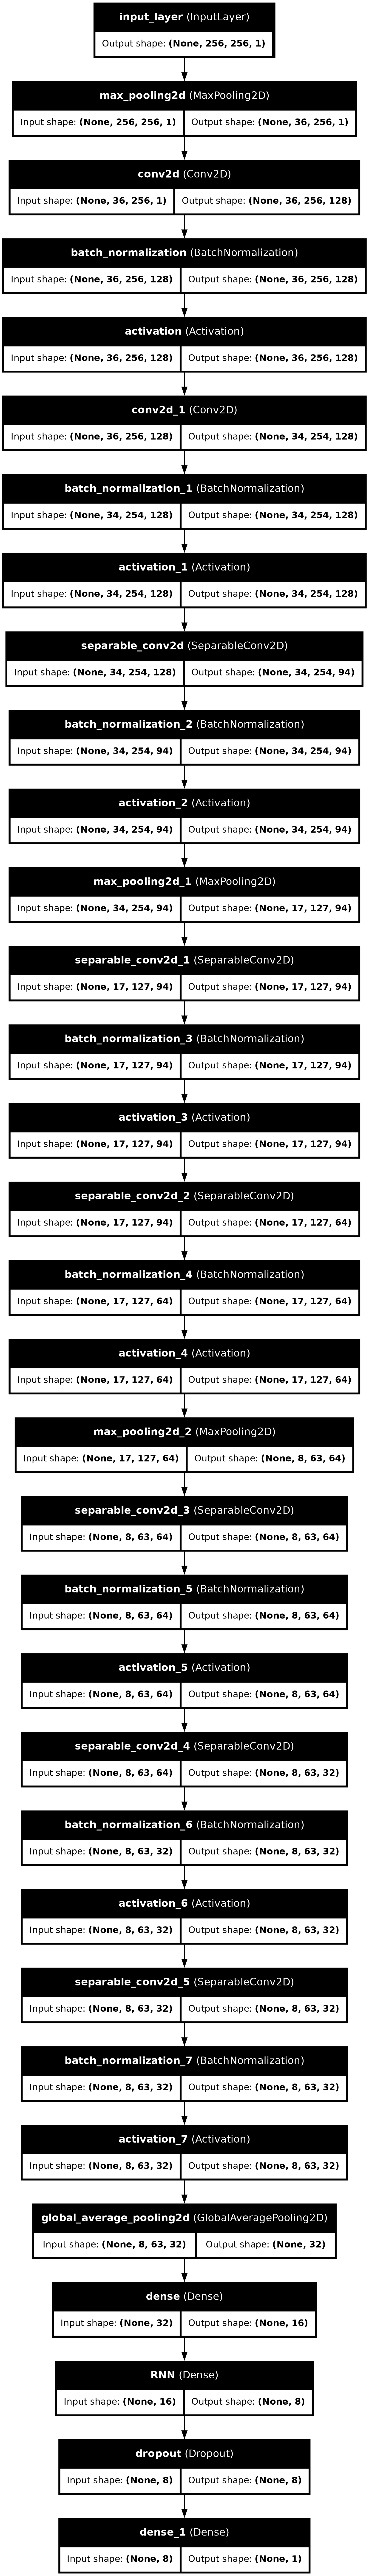

In [17]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model,to_file='model.png',show_shapes=True,show_layer_names=True)
Image(filename='model.png')

In [18]:
# test_uuid = "FA4DC2D8-C0D9-4ECB-A319-70F156E3AF31"
# rxs = np.fromfile(vpath+test_uuid+".bins", dtype=np.uint16 ).astype('float32')
# rxs -= rxs.mean()
# rxs /= rxs.std()+0.0001
# rxs = np.reshape( rxs, (-1,256,256,1), 'C')
# rys = np.loadtxt(vpath+test_uuid+".labels", dtype=np.float32)

# validation_uuid = "FA4DC2D8-C0D9-4ECB-A319-70F156E3AF31"
# xs = np.fromfile(vpath+validation_uuid+".bins", dtype=np.uint16 ).astype('float32')
# xs -= xs.mean()
# xs /= xs.std()+0.0001
# xs = np.reshape( xs, (-1,256,256,1), 'C')
# ys = np.loadtxt(vpath+validation_uuid+".labels", dtype=np.float32)


In [19]:
# #List all files in the directory
# validation_files=os.listdir(vpath)

# #Randomly select a file for validation
# validation_file=random.choice(validation_files)

# #Load and preprocess validation data
# xs=np.fromfile(os.path.join(vpath,validation_file.split(".")[0]+".bins"),dtype=np.uint16).astype('float32')
# xs-=xs.mean()
# xs/=xs.std()+0.0001
# xs=np.reshape(xs,(-1,256,256,1),'C')
# ys = np.loadtxt(os.path.join(vpath,validation_file.split(".")[0]+".labels"), dtype=np.float32)[:, 0]  # corrected here

In [20]:
def load_validation_data(vpath):
    xs, ys = [], []
    for fname in os.listdir(vpath):
        if fname.endswith(".bins"):
            x = np.fromfile(os.path.join(vpath, fname), dtype=np.uint16).astype('float32')
            x -= x.mean()
            x /= x.std() + 1e-5
            x = np.reshape(x, (-1, 256, 256, 1), 'C')
            y = np.loadtxt(os.path.join(vpath, fname.replace('.bins', '.labels')))[:, 0]

            xs.extend(x)
            ys.extend(y)
    return np.array(xs), np.array(ys)

val_xs, val_ys = load_validation_data(vpath)
assert val_xs.shape[0] == val_ys.shape[0]


In [21]:
class DebugCallback(keras.callbacks.Callback):
#    def on_batch_end(self, batch, logs={}):
    def on_epoch_end(self, epoch, logs={} ):
        predictions = model.predict(xs)
        res = np.concatenate((ys, predictions), -1)
        # plt.plot(res[:, 1], res[:, 2], 'bo')
        # plt.show()
        #plt.savefig("out.png")

In [22]:
# # Reshape your input data to match the model's output shape
# rxs_all=np.reshape(rxs_all,(-1,256,256,1))

# #Assuming rys_all is a 2D array with shape (num_samples,2)
# #Extract the binary classification labels(assuming binary classification)
# rys_binary=rys_all[:,0] #Assuming the first column contains the binary labels

# print("Input Data shape: ",rxs_all.shape)
# print("Labels shape: ",rys_binary.shape)

In [23]:
# Implement Early Stopping and Learning Rate Scheduler
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

In [24]:
debug = DebugCallback()

# callbacks = [  keras.callbacks.TensorBoard(log_dir='log', histogram_freq=1)
#              , keras.callbacks.ModelCheckpoint( 'modelcpnt'+str(run_uuid)+'.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
#              , debug ]


# history=model.fit_generator(data_generator(100),epochs=50,validation_data= (xs,ys[:,0]),steps_per_epoch=60,callbacks=callbacks)
# Model compilation with binary accuracy
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc')])


# Model training using augmented generator
# Proper training
history = model.fit(
    data_generator(batch_size=10),
    steps_per_epoch=500,
    epochs=100,
    validation_data=(val_xs, val_ys),
    callbacks=callbacks
)

Epoch 1/100


I0000 00:00:1745211172.154496      69 service.cc:145] XLA service 0x7a577c002ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745211172.154559      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/500 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.7667 - auc: 0.8013 - loss: 0.5758 - precision: 0.7877 - recall: 0.8852   

I0000 00:00:1745211180.808544      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.5815 - auc: 0.6227 - loss: 0.6530 - precision: 0.6162 - recall: 0.8125 - val_accuracy: 0.6850 - val_auc: 0.8623 - val_loss: 0.6736 - val_precision: 1.0000 - val_recall: 0.4324 - learning_rate: 1.0000e-05
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.6087 - auc: 0.6613 - loss: 0.6266 - precision: 0.6323 - recall: 0.8619 - val_accuracy: 0.5550 - val_auc: 0.9936 - val_loss: 0.5914 - val_precision: 0.5550 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.6351 - auc: 0.6993 - loss: 0.6122 - precision: 0.6550 - recall: 0.8449 - val_accuracy: 0.6000 - val_auc: 0.9913 - val_loss: 0.5750 - val_precision: 0.5812 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.6703 - auc: 0.7413 - loss: 0.6000 - precision: 0.6828 - recall: 0.8443 - val_accuracy: 0.6200 - val_auc: 0.9963 - val_loss: 

In [25]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
callbacks.append(checkpoint)

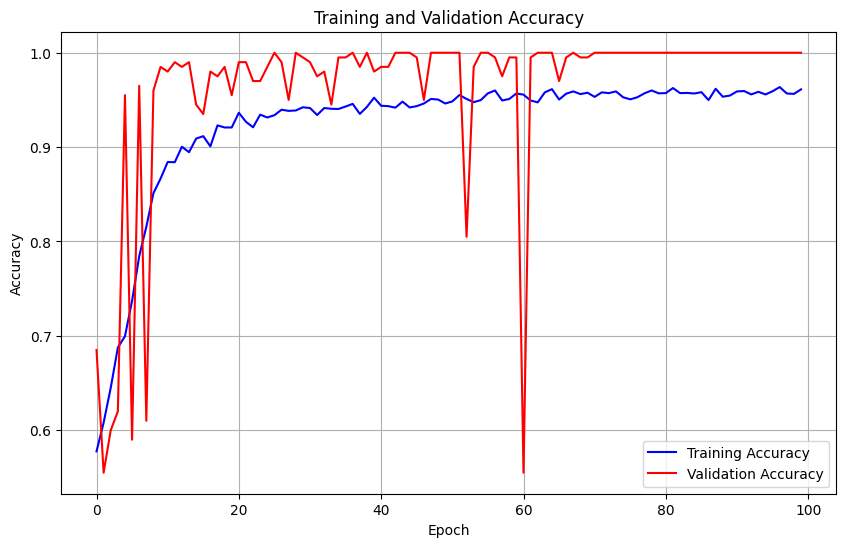

In [26]:
# Extract training history correctly
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Predict on validation set
y_pred = (model.predict(val_xs) > 0.5).astype(int).reshape(-1)

# Ensure labels are correctly shaped
val_ys = val_ys.reshape(-1).astype(int)

# Classification Report
print(classification_report(val_ys, y_pred, target_names=['Class 0', 'Class 1']))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        89
     Class 1       1.00      1.00      1.00       111

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



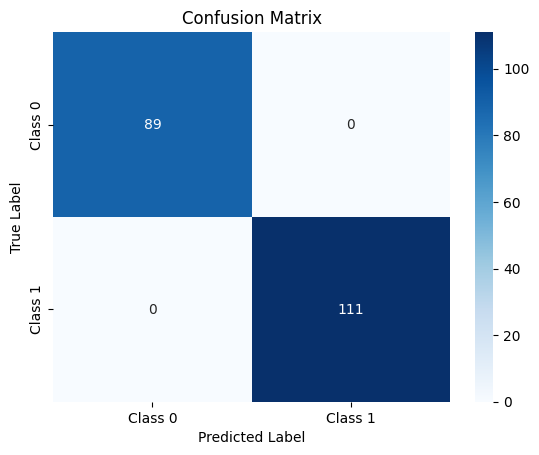

In [28]:
# Confusion Matrix
cm = confusion_matrix(val_ys, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

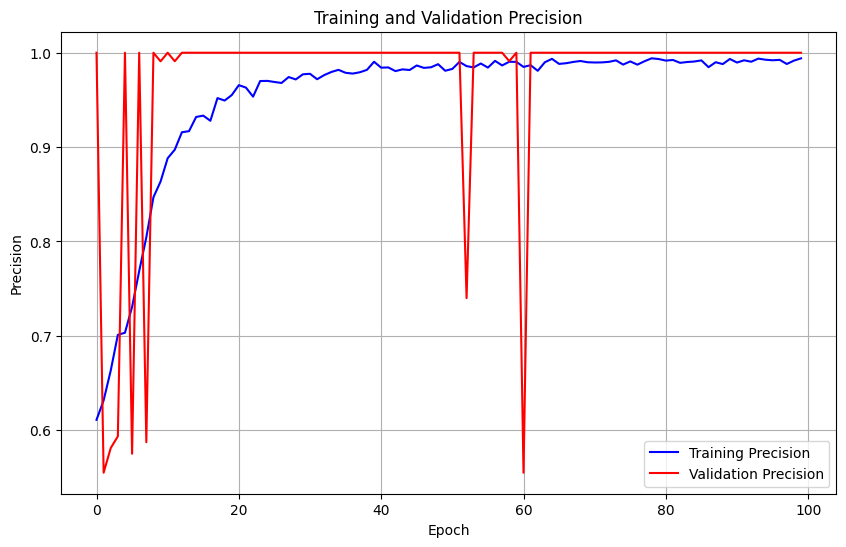

In [29]:
# Extract training history correctly
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['precision']
val_acc = history.history['val_precision']

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Precision', color='blue')
plt.plot(val_acc, label='Validation Precision', color='red')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

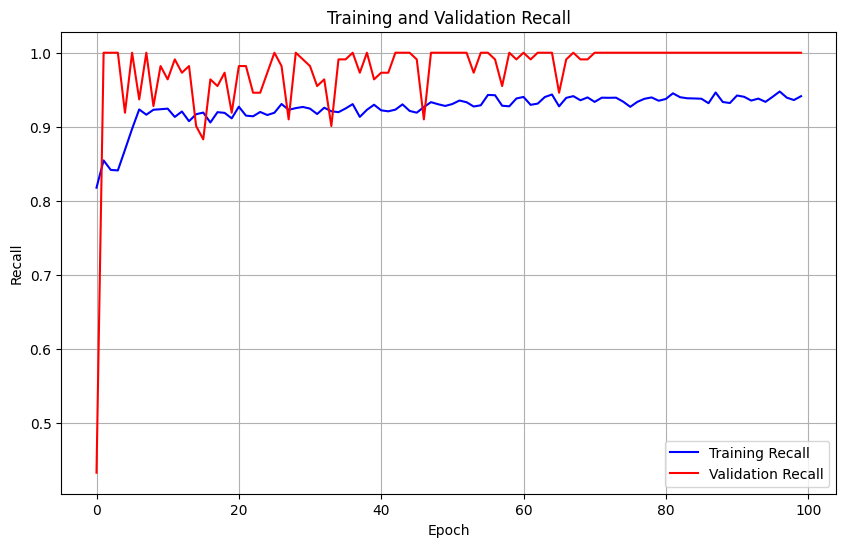

In [30]:
# Extract training history correctly
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['recall']
val_acc = history.history['val_recall']

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Recall', color='blue')
plt.plot(val_acc, label='Validation Recall', color='red')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()

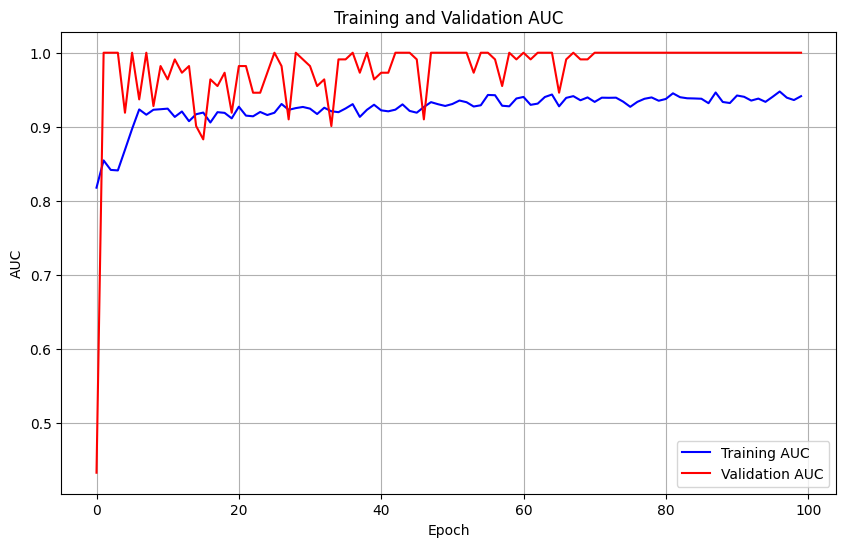

In [31]:
# Extract training history correctly
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['auc']
val_auc = history.history['val_auc']

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training AUC', color='blue')
plt.plot(val_acc, label='Validation AUC', color='red')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()